In [90]:
# !pip3 install bayesian-optimization

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn import metrics as skmetrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from bayes_opt import BayesianOptimization

In [92]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
sns.set(rc={'figure.figsize':(5,10)})


In [93]:
X_smote = pd.read_csv('data/X_smote.csv')
y_smote = pd.read_csv('data/y_smote.csv')

X_val = pd.read_csv('data/X_val.csv')
y_val = pd.read_csv('data/y_val.csv')

X_test = pd.read_csv('data/X_test.csv')
y_test = pd.read_csv('data/y_test.csv')

In [94]:
def print_statistics(y_actual, y_pred, y_pred_prob, dataset_type):
  print(f"====================={dataset_type}====================")
  print(f"accuracy: {round(skmetrics.accuracy_score(y_actual, y_pred),5)}")
  print(f"precision: {round(skmetrics.precision_score(y_actual, y_pred),5)}")
  print(f"recall: {round(skmetrics.recall_score(y_actual, y_pred),5)}")
  print(f"f1 score: {round(skmetrics.f1_score(y_actual, y_pred),5)}")
  prec, recall, thresholds = skmetrics.precision_recall_curve(y_actual, y_pred_prob)
  print(f'pr auc: {round(skmetrics.auc(recall, prec), 5)}')


## Random Forest

In [95]:
rf = RandomForestClassifier()
rf_model = rf.fit(X_smote, y_smote)

y_pred_train = rf_model.predict(X_smote)
y_pred_train_proba = rf_model.predict_proba(X_smote)[:, 1]
print_statistics(y_smote, y_pred_train, y_pred_train_proba, 'train')

y_pred_val = rf_model.predict(X_val)
y_pred_val_proba = rf_model.predict_proba(X_val)[:, 1]
print_statistics(y_val, y_pred_val, y_pred_val_proba, 'val')

y_pred_test = rf_model.predict(X_test)
y_pred_test_proba = rf_model.predict_proba(X_test)[:, 1]
print_statistics(y_test, y_pred_test, y_pred_test_proba, 'test')

/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2399065869.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model = rf.fit(X_smote, y_smote)


=====================train====================
accuracy: 0.99994
precision: 1.0
recall: 0.99988
f1 score: 0.99994
pr auc: 1.0
=====================val====================
accuracy: 0.94799
precision: 0.94737
recall: 0.85494
f1 score: 0.89879
pr auc: 0.88303
=====================test====================
accuracy: 0.94487
precision: 0.94798
recall: 0.84211
f1 score: 0.89191
pr auc: 0.87183


## Extra Trees Classifier

In [96]:
xtc = ExtraTreesClassifier()
xtc_model = xtc.fit(X_smote, y_smote)

y_pred_train = xtc_model.predict(X_smote)
y_pred_train_proba = xtc_model.predict_proba(X_smote)[:, 1]
print_statistics(y_smote, y_pred_train, y_pred_train_proba, 'train')

y_pred_val = xtc_model.predict(X_val)
y_pred_val_proba = xtc_model.predict_proba(X_val)[:, 1]
print_statistics(y_val, y_pred_val, y_pred_val_proba, 'val')

y_pred_test = xtc_model.predict(X_test)
y_pred_test_proba = xtc_model.predict_proba(X_test)[:, 1]
print_statistics(y_test, y_pred_test, y_pred_test_proba, 'test')

/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/433721700.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


=====================train====================
accuracy: 1.0
precision: 1.0
recall: 1.0
f1 score: 1.0
pr auc: 1.0
=====================val====================
accuracy: 0.94209
precision: 0.92618
recall: 0.85366
f1 score: 0.88844
pr auc: 0.88567
=====================test====================
accuracy: 0.94105
precision: 0.93813
recall: 0.83697
f1 score: 0.88467
pr auc: 0.87187


## Tune the ExtraTrees classifier

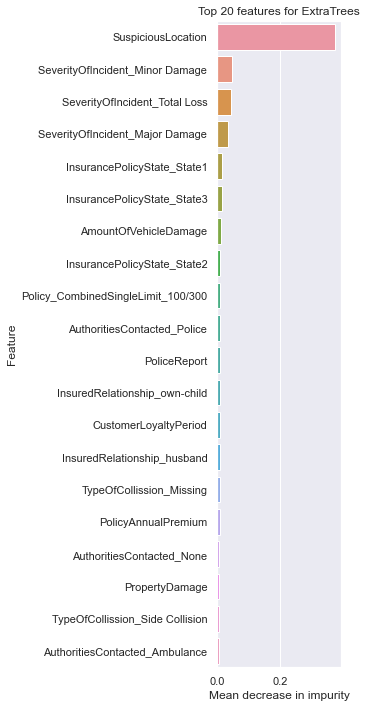

In [97]:
feature_names = [f"{X_smote.columns[i]}" for i in range(X_smote.shape[1])]

importances = xtc_model.feature_importances_

forest_importances = pd.DataFrame({'feature': feature_names,
                                    'importance': importances}
                                    )
forest_importances = forest_importances.sort_values('importance', ascending=False)
forest_importances = forest_importances[:20] # top 20

fig, ax = plt.subplots(1,1)
sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(y='feature', x='importance', ax=ax, data=forest_importances, orient="h")
ax.set_title("Top 20 features for ExtraTrees")
ax.set_xlabel("Mean decrease in impurity")
ax.set_ylabel("Feature")
fig.tight_layout()

## Bayesian optimization of ExtraTrees for hyperparameter tuning

In [98]:
seed = 1

def extratrees(n_estimators,
                max_depth,
                min_samples_split,
                min_samples_leaf,
                max_features,
                bootstrap):

    n_estimators = int(n_estimators)
    max_depth = int(max_depth) # Pre-pruning technique
    min_samples_split = int(min_samples_split) # Pre-pruning technique
    min_samples_leaf = int(min_samples_leaf) # Pre-pruning technique
    bootstrap = bootstrap > 0.5
    
    assert type(n_estimators) == int
    assert type(max_depth) == int
    assert type(min_samples_split) == int
    assert type(min_samples_leaf) == int


    xtc = ExtraTreesClassifier(n_estimators=n_estimators,
                               max_depth=max_depth,
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               max_features=max_features,
                               bootstrap=bootstrap,
                               oob_score=bootstrap,
                               n_jobs=6,
                               random_state=seed,
                               verbose=0)

    xtc_model = xtc.fit(X_smote, y_smote)
    # use validation set to evaluate performance - F1 is our main metric
    y_pred_val = xtc_model.predict(X_val)
    return skmetrics.f1_score(y_val, y_pred_val)

In [99]:
# space to search
# params = {'n_estimators': (25, 251),
params = {'n_estimators': (25, 150),
          'max_depth' : (10, 200),
          'min_samples_split': (2,15),
          'min_samples_leaf' : (2,15),
          'max_features' : (.2,.8),
          'bootstrap':(0,1),
          } 

xtcBO = BayesianOptimization(extratrees, 
                            pbounds = params, 
                            random_state = seed)

print(xtcBO.space.keys)

['bootstrap', 'max_depth', 'max_features', 'min_samples_leaf', 'min_samples_split', 'n_estimators']


In [100]:
xtcBO.maximize(init_points=6, 
               n_iter=25,
               acq = 'ucb',
               xi = 0.0,
               alpha = 1e-6)

|   iter    |  target   | bootstrap | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 1         | 0.9003    | 0.417     | 146.9     | 0.2001    | 5.93      | 3.908     | 36.54     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 2         | 0.901     | 0.1863    | 75.66     | 0.4381    | 9.005     | 7.45      | 110.7     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 3         | 0.9003    | 0.2045    | 176.8     | 0.2164    | 10.72     | 7.425     | 94.84     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 4         | 0.901     | 0.1404    | 47.64     | 0.6804    | 14.59     | 6.075     | 111.5     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 5         | 0.9003    | 0.8764    | 180.0     | 0.251     | 2.508     | 4.208     | 134.8     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 6         | 0.9004    | 0.09835   | 90.01     | 0.7747    | 8.931     | 10.99     | 64.44     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 7         | 0.901     | 0.753     | 75.99     | 0.6154    | 8.275     | 5.763     | 109.7     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 8         | 0.901     | 0.8898    | 64.63     | 0.4558    | 4.792     | 3.753     | 149.3     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 9         | 0.9003    | 0.502     | 11.87     | 0.3515    | 5.441     | 14.69     | 149.9     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 10        | 0.9003    | 0.1065    | 10.17     | 0.26      | 11.87     | 4.239     | 32.02     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 11        | 0.901     | 0.2829    | 105.7     | 0.373     | 11.58     | 2.119     | 146.1     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 12        | 0.901     | 0.5235    | 78.33     | 0.5264    | 13.46     | 2.001     | 127.3     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 13        | 0.901     | 0.6643    | 82.62     | 0.5992    | 2.068     | 14.28     | 141.5     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 14        | 0.901     | 0.6734    | 53.64     | 0.7705    | 2.695     | 2.54      | 117.7     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 15        | 0.901     | 0.6906    | 50.92     | 0.6449    | 2.921     | 13.01     | 91.56     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 16        | 0.9003    | 0.8497    | 81.69     | 0.2756    | 13.24     | 14.97     | 149.1     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 17        | 0.901     | 0.3848    | 95.8      | 0.4494    | 3.729     | 8.963     | 122.9     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 18        | 0.9003    | 0.2112    | 70.52     | 0.2866    | 2.08      | 13.54     | 129.7     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 19        | 0.9004    | 0.3551    | 56.14     | 0.7236    | 5.3       | 6.055     | 105.3     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 20        | 0.901     | 0.1497    | 78.39     | 0.3922    | 9.669     | 5.556     | 119.2     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 21        | 0.901     | 0.2496    | 87.04     | 0.2693    | 6.4       | 4.604     | 127.2     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 22        | 0.901     | 0.9453    | 87.75     | 0.7547    | 13.11     | 7.736     | 118.5     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 23        | 0.9003    | 0.9626    | 45.93     | 0.3088    | 11.12     | 2.468     | 121.1     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 24        | 0.901     | 0.6431    | 86.64     | 0.6846    | 3.643     | 7.87      | 116.5     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 25        | 0.901     | 0.8522    | 89.6      | 0.631     | 8.596     | 12.33     | 124.7     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 26        | 0.901     | 0.7905    | 95.28     | 0.5907    | 4.14      | 8.435     | 136.3     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 27        | 0.9003    | 0.6998    | 98.2      | 0.2315    | 14.35     | 5.699     | 128.5     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 28        | 0.9004    | 0.1953    | 84.87     | 0.5087    | 2.627     | 11.26     | 133.2     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 29        | 0.901     | 0.528     | 82.39     | 0.3927    | 10.97     | 8.135     | 124.9     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 30        | 0.901     | 0.8997    | 85.77     | 0.4595    | 7.9       | 3.144     | 121.4     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 31        | 0.9003    | 0.6905    | 82.53     | 0.3343    | 11.02     | 13.14     | 116.1     |


In [101]:
# Best Hyperparameters selected
xtcBO.max

{'target': 0.901010101010101,
 'params': {'bootstrap': 0.1862602113776709,
  'max_depth': 75.65653813817907,
  'max_features': 0.438060484538402,
  'min_samples_leaf': 9.00461754204364,
  'min_samples_split': 7.449528687242832,
  'n_estimators': 110.65243754959494}}

In [102]:
xtc_tuned = ExtraTreesClassifier(n_estimators = int(xtcBO.max['params']['n_estimators']),
                                    max_depth = int(xtcBO.max['params']['max_depth']),
                                    min_samples_split = int(xtcBO.max['params']['min_samples_split']),  
                                    min_samples_leaf = int(xtcBO.max['params']['min_samples_leaf']),
                                    max_features =  xtcBO.max['params']['max_features'],                 
                                    bootstrap = xtcBO.max['params']['bootstrap'] > 0.5,
                                    oob_score = xtcBO.max['params']['bootstrap'] > 0.5,
                                    n_jobs=6)

xtc_tuned_model = xtc_tuned.fit(X_smote, y_smote)

y_pred_train = xtc_tuned_model.predict(X_smote)
y_pred_train_proba = xtc_tuned_model.predict_proba(X_smote)[:, 1]
print_statistics(y_smote, y_pred_train, y_pred_train_proba, 'train')

y_pred_val = xtc_tuned_model.predict(X_val)
y_pred_val_proba = xtc_tuned_model.predict_proba(X_val)[:, 1]
print_statistics(y_val, y_pred_val, y_pred_val_proba, 'val')

y_pred_test = xtc_tuned_model.predict(X_test)
y_pred_test_proba = xtc_tuned_model.predict_proba(X_test)[:, 1]
print_statistics(y_test, y_pred_test, y_pred_test_proba, 'test')

/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/1080922815.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_tuned_model = xtc_tuned.fit(X_smote, y_smote)


=====================train====================
accuracy: 0.9587
precision: 0.9794
recall: 0.93712
f1 score: 0.95779
pr auc: 0.9978
=====================val====================
accuracy: 0.94903
precision: 0.94759
recall: 0.85879
f1 score: 0.90101
pr auc: 0.88481
=====================test====================
accuracy: 0.94556
precision: 0.95072
recall: 0.84211
f1 score: 0.89312
pr auc: 0.86682
